# Multi-dataset, Multi-Model, Transform Learning Demo
- This demo has CIFAR-10, ImageNet, Hymenoptera datasets 
- And ResNet18, ResNet19, AlexNet, VGG, PlainNet models.
- Could choice fine tuning or feature extract.

# Bunch of Setups

In [1]:
# import compute module
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

# import plot module
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Training Device Depends on Your hardware.

print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.5.0


# Main Parameters and Hyperparameters 
- data_dir 
- num_classes, batch_size, num_epochs 
- feature_extract 
- model_name
- input_size 

In [3]:
batch_size, num_epochs = 4, 100
feature_extract = True

In [4]:
print("Which modele you want train? ")
print("ResNet18, ResNet152, AlexNet, VGG19, DenseNet121 models")
model_name = input("Please input the model name same above: ")

Which modele you want train? 
ResNet18, ResNet152, AlexNet, VGG19, DenseNet121 models
Please input the model name same above: VGG19


In [5]:
print("Which dataset you want train? (ImageNet is not avalible) ")
print("CIFAR-10, ImageNet, Hymenoptera")
name_dataset = input("Please input the name of dataset from below: ")
if name_dataset=='Hymenoptera':
    data_dir, num_classes, input_size= "./hymenoptera_data", 2, 224
elif name_dataset=='CIFAR-10':
    data_dir, num_classes, input_size = "./CIFAR10_data", 10, 32
elif name_dataset=='ImageNet':
    data_dir, num_classes, input_size = "./Image_data", 1000, 32

Which dataset you want train? (ImageNet is not avalible) 
CIFAR-10, ImageNet, Hymenoptera
Please input the name of dataset from below: CIFAR-10


# Dataload Function with Preprocess
- std and mean per channel function
- Batch Normaliszation
- Random Horizon Flip
- Random Resize

In [6]:
# Extract mean and std for training dataset for each channel.
def stdandmean(data_dir, batch_size, shuffle=True, num_workers=4):
    '''
    input: data_dir, batch_size, shuffle=True, num_workers=4
    return: mean, std
    '''
    mean = []
    std = []
    
    data_transform = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(input_size), #将图片裁剪成指定尺寸
            transforms.RandomHorizontalFlip(), #随机翻转图片
            transforms.ToTensor(),
        ]),
    }
    
    if name_dataset=='CIFAR-10':
        img_datasets = datasets.CIFAR10(data_dir, train=True, download=True, transform=data_transform["train"])
    else:
        img_datasets = datasets.ImageFolder(os.path.join(data_dir), data_transform["train"])  
        
    arr_data = [d[0].data.numpy() for d in img_datasets]
    
    for i in range(3):
        mm = [d[i,:,:] for d in arr_data]
        stdd = [d[i,:,:] for d in arr_data]
        mean.append(np.mean(mm))
        std.append(np.std(stdd))
        
    return mean, std


In [7]:
# Transfrom Compact
mean, std = stdandmean(data_dir, batch_size)
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size), #将图片裁剪成指定尺寸
        transforms.RandomHorizontalFlip(), #随机翻转图片
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size), #将图片裁剪成指定尺寸
        transforms.CenterCrop(input_size), # Center Crop the Image.
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}
print(mean)
print(std)

Files already downloaded and verified
[0.48999745, 0.47329083, 0.4372805]
[0.23513092, 0.23149233, 0.24761415]


In [8]:
# Load Data
if name_dataset=='CIFAR-10':
    train_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10(data_dir, train=True, download=True,transform=data_transform["val"]), 
        batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10(
            data_dir, train=False, download=True,transform=data_transform["train"]), 
        batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )

    dataloaders_dict = {"train": train_dataloader
                        , "val": test_dataloader}
else:
    img_datasets = {x: datasets.ImageFolder(os.path.join(data_dir), data_transform[x]) for x in ["train", "val"]}
    dataloaders_dict = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

Files already downloaded and verified
Files already downloaded and verified


# Initialization of Modle
- model list: ResNet18, ResNet152, AlexNet, VGG19, DenseNet201

In [10]:
def set_parameter_requires_grad(model, feature_extract):
    """
    model
      A Neural Network model comes from torchvision.model .
    feature_extrace = True or False.
    It means change a parts of weights while training, istead of entire model's weights.
    
    This function do nothing while feature_extrace = False.
    """
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False # Set all parameters in model no update.
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True): 
    """
    model_name: 
      ResNet18, ResNet152, AlexNet, VGG19, DenseNet201 
    num_classes:
      The number of classes in your dataset.
    feature_extrace: 
      use_pretrained = True or False. 
      It means the model you get had or hadn'd been trained.
    
    model_ft is a model(Pretrained=True)
    
    """
    if model_name == "ResNet18":
        model_ft = models.resnet18(pretrained=use_pretrained) # models.resnet18(pretrainen=False, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract) 
        
        num_ftrs = model_ft.fc.in_features # model_ft.fc就是模型之中全部fc层，in_features 拿出参数
        model_ft.fc = nn.Linear(num_ftrs, num_classes) 
        
    elif model_name == "ResNet152":
        model_ft = models.resnet152(pretrained=use_pretrained) # models.resnet18(pretrainen=False, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract) 
        
        num_ftrs = model_ft.fc.in_features # model_ft.fc就是模型之中全部fc层，in_features 拿出参数
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "AlexNet":
        model_ft = models.alexnet(pretrained=use_pretrained) 
        set_parameter_requires_grad(model_ft, feature_extract) 
        
        num_ftrs = model_ft.classifier[6].in_features 
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)  
        
    elif model_name == "VGG19":
        model_ft = models.vgg19(pretrained=use_pretrained) 
        set_parameter_requires_grad(model_ft, feature_extract) 
        
        num_ftrs = model_ft.classifier[6].in_features 
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)  
    
    elif model_name == "DenseNet121":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) 
        
        num_ftrs = model_ft.classifier.in_features 
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        print("model not implemented")
        return None, None
        
    return model_ft

# Define train progress Funtion contained Train & Test
- model which all ready inited.
- Train and Val Dataloader dataset
- loss function
- optimizer
- num of epochs, init to 5

In [11]:
#def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
def train_model(model, dataloaders, loss_fn, lr=0.1, num_epochs=5):
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
    
    best_model_wts = copy.deepcopy(model.state_dict()) # init the best_weights data.
    best_acc = 0. # init best accuracy as 0.
    val_acc_history = [] # Creat a list contrains accuracy history data.
    val_loss_history = [] # Creat a list contrains training loss history data.
    lr_history = [] # learning rate history
    val_error = []
    
    for epoch in range(num_epochs): # For each process epochs.
        for phase in ["train", "val"]: # Train and Val phase.
            running_loss = 0. 
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]: # Gain the input datas and labels.
                inputs, labels = inputs.to(device), labels.to(device) # Remove datas and labels to CUDA capable device.
                
                with torch.autograd.set_grad_enabled(phase=="train"): # if training phase, requeire the grad.
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels) 
                    
                preds = outputs.argmax(dim=1) # The prediction of training process.
                if phase == "train": # ipdata the weight.
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_error = 1 - epoch_acc
            
            print("Epoch:{}, Phase: {}, loss: {}, acc: {}, error: {}".format(epoch+1, phase, epoch_loss, epoch_acc,epoch_error))
            
            
            if phase == "val" and epoch_acc > best_acc: # save the best weights.
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == "val":  # Save val accuracy and loss history.
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_error.append(epoch_error)
                lr_history.append(lr)
                
            grad_val_acc = 1e4
            print("lr: {}".format(lr))
            
            # Update optimizer
            if phase =="val" and epoch > 2:
                grad_val_acc = np.abs((val_acc_history[epoch-1] - val_acc_history[epoch]) / 2)
                if lr==0.1 and 0 < grad_val_acc < 0.01:
                    lr /= 10
                elif lr==0.01 and 0 < grad_val_acc < 0.002:
                    lr /= 10
                elif lr==0.001 and 0 < grad_val_acc < 0.0009:
                    lr /= 10
                optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
            
            if grad_val_acc != 1e4:
                print("grad_val_acc: {}".format(grad_val_acc))  
            torch.cuda.empty_cache()
    
    model.load_state_dict(best_model_wts)    # best model.
    
    return model, val_acc_history, val_loss_history, val_error, lr_history

In [12]:
# Use Pretrained model

model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

loss_fn = nn.CrossEntropyLoss()

_, acc_hist, loss_hist, err_hist, lr_hist = train_model(model_ft, dataloaders_dict, loss_fn, lr=0.1, num_epochs=num_epochs) 
# return model, val_acc_history, val_loss_history, val_error, lr_history

Epoch:1, Phase: train, loss: 1034.6090930975533, acc: 0.46162, error: 0.5383800000000001
lr: 0.1
Epoch:1, Phase: val, loss: 857.953864666748, acc: 0.4583, error: 0.5417000000000001
lr: 0.1
Epoch:2, Phase: train, loss: 1165.8955349975586, acc: 0.48694, error: 0.5130600000000001
lr: 0.1
Epoch:2, Phase: val, loss: 940.3289299041749, acc: 0.465, error: 0.5349999999999999
lr: 0.1
Epoch:3, Phase: train, loss: 1179.643141871338, acc: 0.49362, error: 0.50638
lr: 0.1
Epoch:3, Phase: val, loss: 949.8050548034668, acc: 0.4737, error: 0.5263
lr: 0.1
Epoch:4, Phase: train, loss: 1200.3011462597656, acc: 0.4964, error: 0.5036
lr: 0.1
Epoch:4, Phase: val, loss: 1046.4555725097657, acc: 0.462, error: 0.538
lr: 0.1
grad_val_acc: 0.005849999999999994
Epoch:5, Phase: train, loss: 882.5097934423828, acc: 0.532, error: 0.46799999999999997
lr: 0.01
Epoch:5, Phase: val, loss: 710.7036253570557, acc: 0.4959, error: 0.5041
lr: 0.01
grad_val_acc: 0.016949999999999993
Epoch:6, Phase: train, loss: 700.76696301147

KeyboardInterrupt: 

In [15]:
# Not Use Pretrained model

model_scratch = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

model_scratch = model_scratch.to(device)

loss_fn = nn.CrossEntropyLoss()

_, sacc_hist, sloss_hist, serr_hist, slr_hist  = train_model(model_scratch, dataloaders_dict, loss_fn, lr=0.1, num_epochs=num_epochs)

KeyboardInterrupt: 

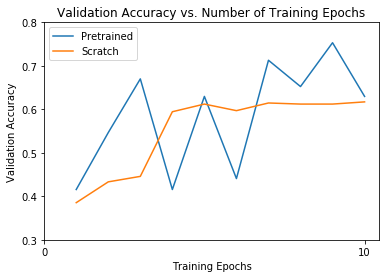

In [15]:
#  Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),acc_hist,label="Pretrained")
plt.plot(range(1,num_epochs+1),sacc_hist,label="Scratch")
plt.ylim((0.3,0.8))
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()

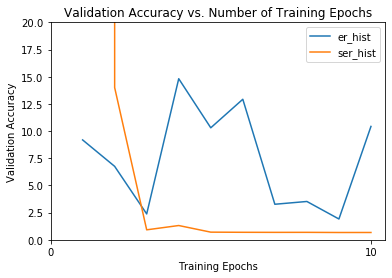

In [17]:
#  Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),loss_hist,label="er_hist")
plt.plot(range(1,num_epochs+1),sloss_hist,label="ser_hist")
plt.ylim(0,20)
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()

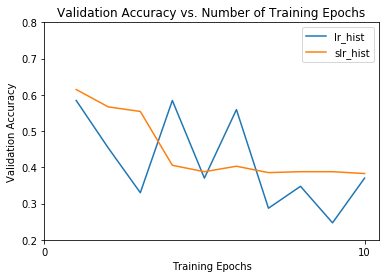

In [21]:
#  Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),err_hist,label="lr_hist")
plt.plot(range(1,num_epochs+1),serr_hist,label="slr_hist")
plt.ylim((0.2,0.8))
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()

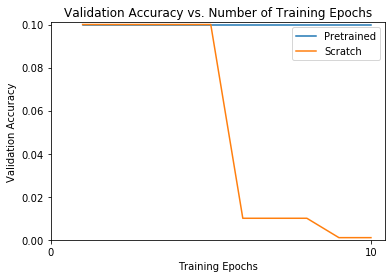

In [22]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),lr_hist,label="Pretrained")
plt.plot(range(1,num_epochs+1),slr_hist,label="Scratch")
plt.ylim((0,0.101))
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()